This data set contains the Pokemon BASE stats based on the Pokemon games, not the cards or Pokemon Go. These are not the max values these stats can be, based on pokemondb.net.

Purpose is to explore the data and compare stats between different Type 1 Pokemon.

In [64]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
import operator

seed=6291

records=pd.read_csv('Data/Pokemon_stats.csv')

records.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [2]:
print("Number of Pokemon: " + str(records.shape[0]))
print(records.describe())

Number of Pokemon: 800
                #      Total          HP      Attack     Defense     Sp. Atk  \
count  800.000000  800.00000  800.000000  800.000000  800.000000  800.000000   
mean   362.813750  435.10250   69.258750   79.001250   73.842500   72.820000   
std    208.343798  119.96304   25.534669   32.457366   31.183501   32.722294   
min      1.000000  180.00000    1.000000    5.000000    5.000000   10.000000   
25%    184.750000  330.00000   50.000000   55.000000   50.000000   49.750000   
50%    364.500000  450.00000   65.000000   75.000000   70.000000   65.000000   
75%    539.250000  515.00000   80.000000  100.000000   90.000000   95.000000   
max    721.000000  780.00000  255.000000  190.000000  230.000000  194.000000   

          Sp. Def       Speed  Generation  
count  800.000000  800.000000   800.00000  
mean    71.902500   68.277500     3.32375  
std     27.828916   29.060474     1.66129  
min     20.000000    5.000000     1.00000  
25%     50.000000   45.000000     2.

We see here that there are no missing values. Let's again remove the "Mega" Pokemon from the dataset.

In [3]:
records_noMega=records[~records['Name'].str.contains("Mega ")]


We want to focus on the differences between the types (Type 1) Pokemon. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

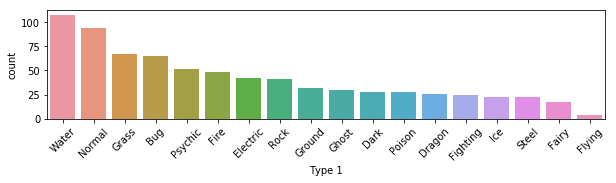

In [4]:
fit, ax=plt.subplots()
fit.set_size_inches(10,2)

sns.countplot(x="Type 1", data=records_noMega, order=records_noMega["Type 1"].value_counts().index)
plt.xticks(rotation=45)

Water and Normal have the most 'observations' so let's start with comparing those two groups. Let's look at the distribution of Type 2 groups across Water and Normal, to see if anything stands out.

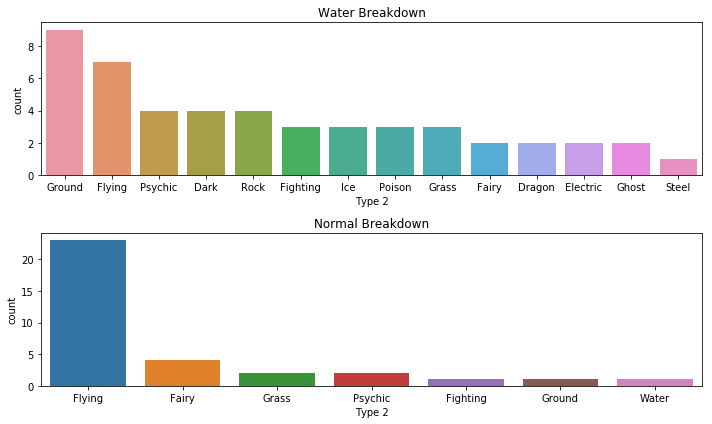

In [6]:
fig, ax=plt.subplots(nrows=2)
fig.set_size_inches(10,6)

water= records_noMega[records_noMega["Type 1"]=="Water"]
normal=records_noMega[records_noMega["Type 1"]=="Normal"]
sns.countplot(x="Type 2", data=water, order=water["Type 2"].value_counts().index , ax=ax[0])
ax[0].set_title('Water Breakdown')

sns.countplot(x="Type 2", data=normal, order=normal["Type 2"].value_counts().index , ax=ax[1])
ax[1].set_title('Normal Breakdown' )

fig.tight_layout()


Flying is a common Type 2 group across Water and Normal, but I can't think of anything do to with this information right now.

Water type Pokemon are known to have good defensive stats across the board. How do Water and Normal type compare?

Water HP mean: 71.32710280373831
Normal HP mean: 76.77659574468085
Population HP mean: 68.68484042553192
 
Water Attack mean: 71.79439252336448
Normal Attack mean: 72.32978723404256
Population Attack mean: 75.98670212765957
 
Water Defense mean: 70.85046728971963
Normal Defense mean: 58.138297872340424
Population Defense mean: 71.78191489361703
 


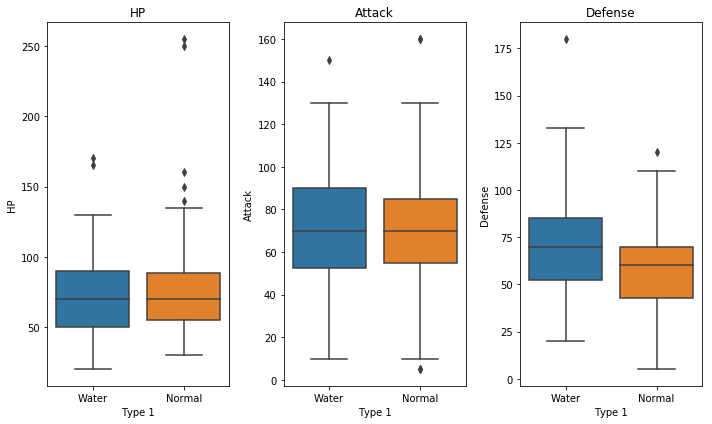

In [48]:
#Attack comparision
focus=pd.concat([water, normal])
stat_list=['HP', 'Attack', 'Defense']
i=0
fig, ax=plt.subplots(ncols=len(stat_list))
fig.set_size_inches(10,6)
for stat in stat_list:
    print("Water "+stat+" mean: " +str(water[stat].mean()))
    print("Normal "+stat+" mean: " +str(normal[stat].mean()))
    print("Population "+stat+" mean: "+str(records_noMega[stat].mean()))
    print(" ")
    sns.boxplot(x="Type 1", y=stat, data=focus,ax=ax[i])
    ax[i].set_title(stat)
    i=i+1
    
fig.tight_layout()

Question 1: The difference in HP between Water and Normal types is 5 HP. Is that significant? Normal has 2 outliers that seem to pull the mean up. What are those outliers?

Question 2: Normal type seem to have a lower average Defense compared to Water and the entire population. Are normal type defensively worse than any other type of Pokemon at their base level?

Throughout this analysis, I have chosen a p-value of 0.05. It is the standard when determining significance and I have no reason to modify it since the cost of a false positive is not important in this analysis.

Let's explore question 1 first.

In [8]:
normal[(normal['HP']-normal['HP'].mean())>=(3*normal['HP'].std())]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
121,113,Chansey,Normal,NaN,450,250,5,5,35,105,50,1,False
261,242,Blissey,Normal,NaN,540,255,10,10,75,135,55,2,False


The two extreme outliers are indeed Chansey and Blissey. Do they change the Normal HP average to be significantly higher than Water type pokemon?

Since I established in the previous Journal Entry (3) that the data was somewhat skewed, I decided to use the Levene test, which is an F-test but uses either the median, mean, or trimmed centers, depending on what your data looks like. I will use the median center due to the skewness of the data. Mean would be too far to the right on the number line in most cases. The default for the scipy levene test is median. Also, since the dataset is currently the entire population of Pokemon, we know the population parameters.

In [33]:
stats.levene(normal['HP'],water['HP'])


LeveneResult(statistic=0.39853689834108458, pvalue=0.52857028178578691)

The p-value is 0.53, which means that the 5 HP difference between Normal and Water Types is purely random noise and is not a significant difference due to another factor (mainly Chansey and Blissy).

What if we tired different sample sizes?

In [21]:
def sample_graph(sample_size, data_standard, data_compare, stat):

    sample_test=pd.DataFrame()
    while sample_size<min(data_standard.shape[0], data_compare.shape[0]):
        data_standard_smpl=data_standard.sample(n=sample_size)
        data_compare_smpl=data_compare.sample(n=sample_size)
        test=stats.levene(data_standard_smpl[stat], data_compare_smpl[stat])
        sample_test=sample_test.append(pd.DataFrame([[sample_size,test.pvalue]]), ignore_index=True)
        sample_size+=5
        
    if sample_test.shape[0]!=0:
        sample_test.columns =['Sample Size', 'P-value']  
        test=sns.lmplot(x='Sample Size', y='P-value', data=sample_test)
        test.fig.suptitle("{0} vs. {1}".format(data_standard.iloc[0]['Type 1'], data_compare.iloc[0]['Type 1']))

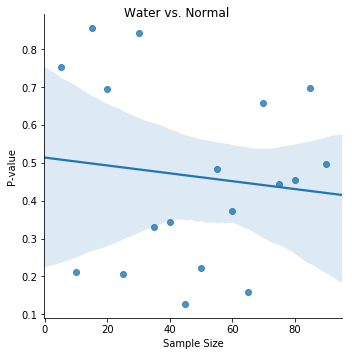

In [25]:
sample_graph(5, water, normal, 'HP')

It might look like there is a trend here, but the pvalues are very spread out and most are nowhere near 0.05. And each time I run this code, the slope changes randomly. This makes sense because each time the pvalue is calculated, the data used in the calculation is different, which yields different standard deviations (square to get variance). The two groups are not significantly different from each other. Smaller samples actually have a better chance of concluding that the difference is significant because the Water samples could be randomly taken from around the center and the Normal samples could be taken from the ends. But this result would be inconsistant each time we run the test, which would tip us off that we need a larger sample size to be more confident.

This graph might look different if the pvalue for the whole population comparision between Water and Normal average HP was indeed significant. The pvalue would converge down to about the significance level of the whole population comparison because the more samples that are added, the more likely the combination of samples will yield a variation that is similar to the population. 

I tried to test this out with the Defense stat. I was surprised that the Levene test showed that the difference between Defense stats of Water and Normal Types was not significant. I wanted to test out my idea of p-value convergence so I set the center as mean instead of median, thinking that would change the results (incorrectly ignoring skewness, I know). 

In [26]:
stats.levene(normal['Defense'],water['Defense'])

LeveneResult(statistic=1.1992310567599944, pvalue=0.27479904331335991)

In [40]:
stats.levene(normal['Defense'],water['Defense'], center='mean')

LeveneResult(statistic=1.1064271933150134, pvalue=0.29413551568980006)

But changing were the center was did not change the results of the Levene test. I think that means that the two groups' variances are not significantly different, that the different pokemon stats are spread out equally, regardless of Water or Normal type. This might be a general rule the Pokemon developers follow.

The difference in means is still nagging at me. I don't know if I'm digging too much into something that I want to see, but I did a t-test with the data instead, to compare the means specifically. Everything tells me that I should not use the t-test on my data since it is skewed and I know the entire population, but I wanted to see what it would look like.

In [38]:
stats.ttest_ind(normal['Defense'],water['Defense'])

Ttest_indResult(statistic=-3.7281485473137654, pvalue=0.00025140194393496779)

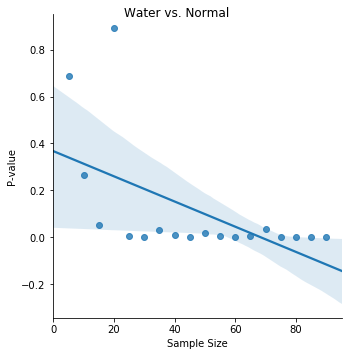

In [39]:
def sample_graph_t(sample_size, data_standard, data_compare, stat):

    sample_test=pd.DataFrame()
    while sample_size<min(data_standard.shape[0], data_compare.shape[0]):
        data_standard_smpl=data_standard.sample(n=sample_size)
        data_compare_smpl=data_compare.sample(n=sample_size)
        test=stats.ttest_ind(data_standard_smpl[stat], data_compare_smpl[stat])
        sample_test=sample_test.append(pd.DataFrame([[sample_size,test.pvalue]]), ignore_index=True)
        sample_size+=5
        
    if sample_test.shape[0]!=0:
        sample_test.columns =['Sample Size', 'P-value']  
        test=sns.lmplot(x='Sample Size', y='P-value', data=sample_test)
        test.fig.suptitle("{0} vs. {1}".format(data_standard.iloc[0]['Type 1'], data_compare.iloc[0]['Type 1']))

sample_graph_t(5, water, normal, 'Defense')

The P-values do indeed converge. Notice how with more samples, the p-values vary less and less and stay around a significant level. Running this function multiple times will yield different starting pvalues, but will still converge. 

The reason I don't have to use a t-test here is that I know the population mean and therefore, how the subgroups compare. Normal is the worst on average across all Types in Defense.

In [63]:
records_noMega.groupby("Type 1")['Defense'].describe().sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
Type 1,,,,,,,,
Normal,94.0,58.138298,22.475603,5.0,43.00,60.0,70.00,120.0
Fighting,25.0,64.280000,18.320116,30.0,53.00,62.0,78.00,95.0
Electric,42.0,65.047619,24.496841,15.0,49.25,61.5,78.50,115.0
Fairy,17.0,65.705882,18.979478,28.0,50.00,66.0,75.00,95.0
Fire,48.0,65.729167,23.147758,37.0,47.25,60.0,72.75,140.0
Flying,4.0,66.250000,21.360009,35.0,61.25,75.0,80.00,80.0
Psychic,52.0,66.596154,29.092995,15.0,47.25,62.5,77.00,160.0
Dark,28.0,67.928571,23.796870,30.0,50.00,67.5,88.50,115.0
Bug,65.0,68.692308,32.222335,30.0,50.00,59.0,86.00,230.0


So for question 2, I focused on how does Water type Defense variation compare to the rest of the types of Pokemon?

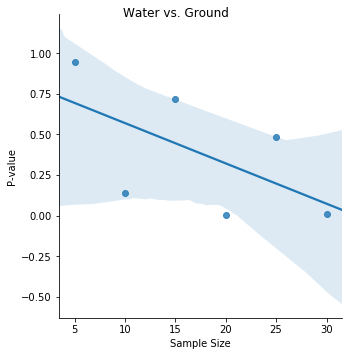

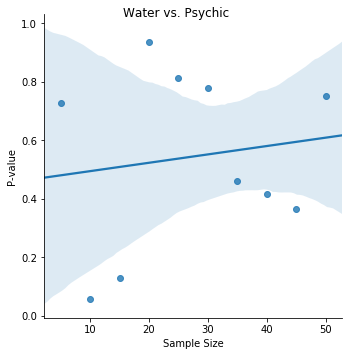

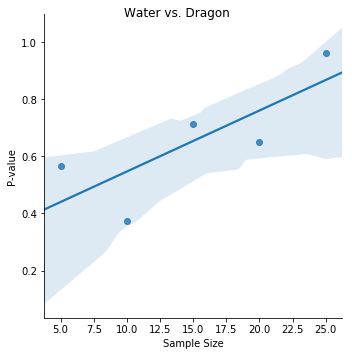

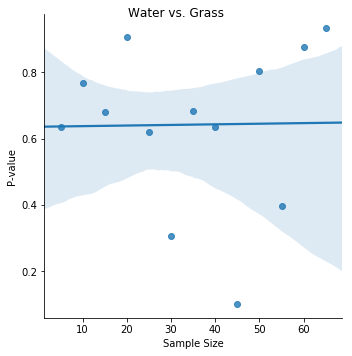

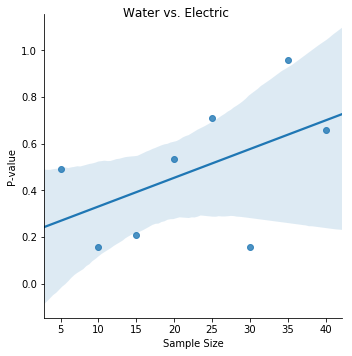

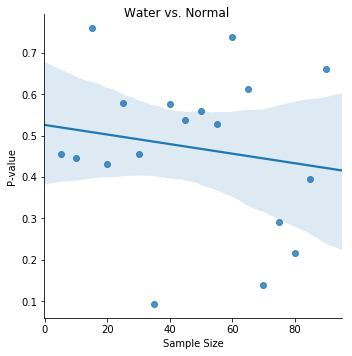

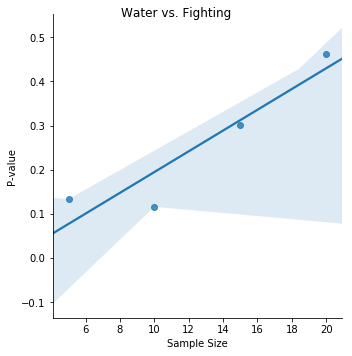

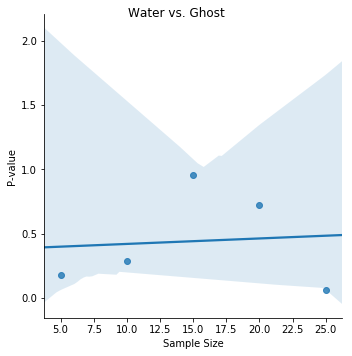

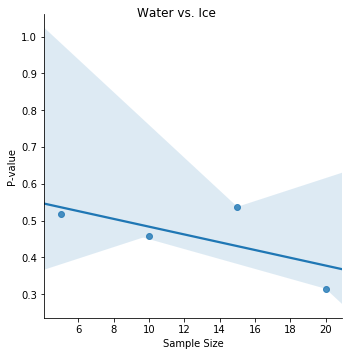

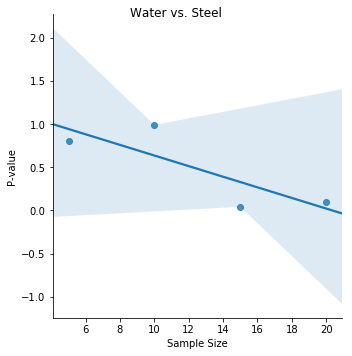

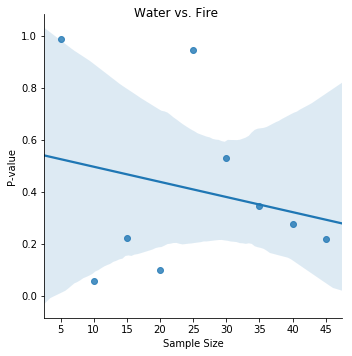

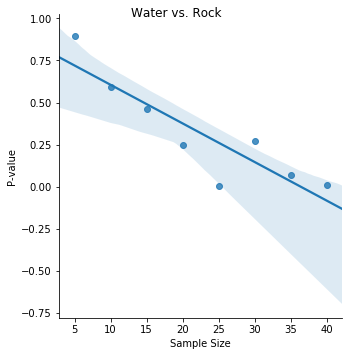

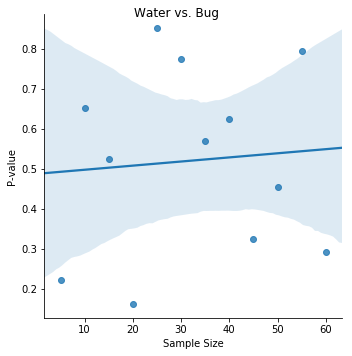

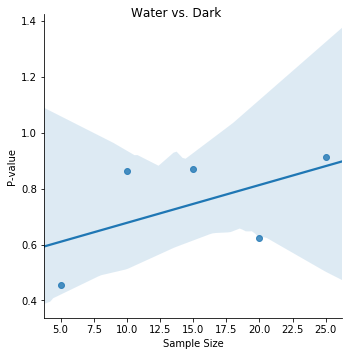

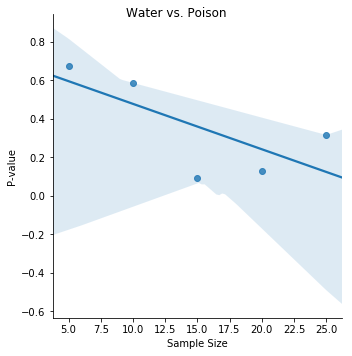

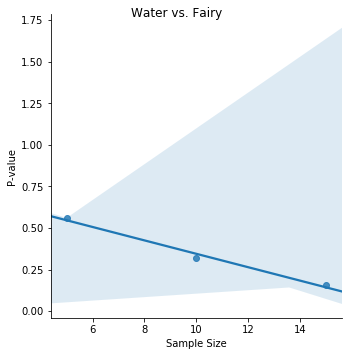

In [42]:
type1_set=set(records_noMega['Type 1'])
type1_set.remove('Water')
for type_name in type1_set:
    type_data=records_noMega[records_noMega['Type 1']==type_name]
    sample_graph(5, water, type_data, 'Defense')

Unsurprisingly, the comparison in Defense variation between Water and the rest of the types of Pokemon seem to be similar. There is no evidence that the variation is determined by anything other than chance. Water vs Rock might be something to look into next time.

Since I was looking into specifically HP and the influence Chansey and Blissey had on it, and how Defense compared across types, I didn't look into multiple comparision effects in this analysis.